# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [01:06<02:10,  4.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [01:24<01:59,  4.41s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  50%|██████████████████████                      | 25/50 [01:27<01:16,  3.06s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source RXCJ1212.3-1816 does not appear to have any XMM dat

In [23]:
from xga.exceptions import NoProductAvailableError

which = []
for src in locuss_srcs:
    try:
        mp = src.get_hydrostatic_mass_profiles()
        which.append(mp.src_name)
    except NoProductAvailableError:
        pass
len(which)

41

In [29]:
locuss[np.isfinite(locuss['x_m500']) & locuss['name'].isin(which)]

,name,ra,dec,z,chandra_id,xmm_obsid,r2500,r1000,r500,c_m2500,...,x_mg1000,x_mg1000_err,x_mg500,x_mg500_err,x_Tx500ce,x_Tx500ce-,x_Tx500ce+,x_Lxbol,x_Lxbol_err,r500wl
0,Abell2697,0.799917,-6.093220,0.232,NaN,0652010401,510.0,840.0,1200.0,NaN,...,5.670000e+13,2.200000e+12,8.800000e+13,3.700000e+12,6.992,0.375,0.477,18.658,0.463,1181.0
1,Abell0068,9.275460,9.158440,0.255,3250,0084230201,580.0,970.0,1400.0,3.850000e+14,...,6.330000e+13,4.000000e+11,9.280000e+13,8.000000e+11,7.658,0.622,0.769,15.863,0.618,1231.0
2,Abell2813,10.853000,-20.623600,0.292,9409,0042340201,500.0,860.0,1240.0,2.540000e+14,...,6.250000e+13,6.000000e+11,9.990000e+13,7.000000e+11,6.322,0.698,0.965,20.197,3.634,1320.0
3,Abell0115S,14.001200,26.342400,0.197,3233,0203220101,350.0,610.0,890.0,8.100000e+13,...,2.640000e+13,1.000000e+11,5.190000e+13,3.000000e+11,5.848,0.300,0.386,9.529,0.213,1115.0
6,Abell0209,22.972200,-13.612200,0.206,"3579,522",0084230301,480.0,800.0,1150.0,1.960000e+14,...,5.310000e+13,2.000000e+11,9.090000e+13,3.000000e+11,7.038,0.483,0.605,19.307,0.596,1513.0
8,Abell0291,30.429100,-2.196190,0.196,NaN,0605000301,380.0,650.0,940.0,NaN,...,2.450000e+13,1.800000e+12,3.910000e+13,3.100000e+12,4.033,0.293,0.324,9.492,0.255,1092.0
9,Abell0383,42.014100,-3.529330,0.188,"2320,524",0084230501,480.0,750.0,1010.0,2.010000e+14,...,3.000000e+13,1.000000e+11,4.330000e+13,2.000000e+11,4.574,0.338,0.420,12.795,0.370,1144.0
10,Abell0521,73.534300,-10.239900,0.248,430,0603890101,270.0,770.0,1230.0,1.700000e+14,...,5.790000e+13,1.000000e+11,1.198000e+14,3.000000e+11,6.718,0.294,0.334,19.036,0.350,1149.0
14,ZwCl0857.9+2107,135.154000,20.894900,0.235,10463,0402250701,420.0,660.0,910.0,1.890000e+14,...,2.630000e+13,2.000000e+11,3.820000e+13,4.000000e+11,4.068,0.277,0.307,17.624,0.916,830.0
16,Abell0773,139.469000,51.727300,0.217,"533,3588,5066",0084230601,560.0,880.0,1210.0,3.230000e+14,...,5.890000e+13,2.000000e+11,8.690000e+13,3.000000e+11,7.525,0.622,0.792,18.319,0.730,1428.0


## Running PSF Correction

In [4]:
rl_psf(locuss_srcs)

## Reading in literature data

### Gas masses from literature

In [5]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [6]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to $R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_beta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500, 
                                          conv_temp=loc_conv_txs)

Running XSPEC Simulations: 100%|████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.90s/it]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [17:15<00:00, 23.01s/it]


In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_1r500_dp)) as onwards:
    for dp in loc_beta_1r500_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [25:10<00:00, 33.56s/it]


In [11]:
loc_beta_king_1r500_gm500 = []
loc_beta_king_1r500_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_1r500_dp)) as onwards:
    for dp in loc_beta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_1r500_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_1r500_gm2500.append(gm)
        else:
            loc_beta_king_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_1r500_gm500 = Quantity(loc_beta_king_1r500_gm500, 'Msun')
loc_beta_king_1r500_gm2500 = Quantity(loc_beta_king_1r500_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:475: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [01:41<00:00,  2.25s/it]


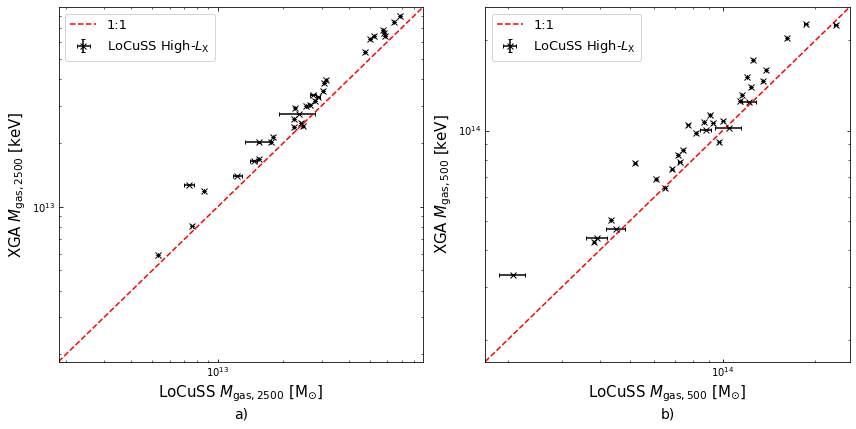

In [12]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_1r500_gm2500, loc_beta_king_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [13]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [14]:
loc_dblbeta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                          conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:26<19:15, 26.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1033.15407248  716.92292967 1537.3354053  1278.91703334 1405.69503518
 1554.24760743]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/45 [00:54<19:34, 27.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.35561156 273.19065466 476.06475126 509.38681592 495.07274487
 492.63556263]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:18<18:16, 26.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1716.54219695 1060.31047881 2063.50264116 1771.93990981 1935.48494692
 2042.57517022]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:42<17:01, 24.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 997.14942037 1781.95481518 2092.78047131 1884.79007289 1940.99905327
 2230.80530388]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▉       | 5/45 [02:06<16:32, 24.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [644.73527329 804.66263954 411.73632419 312.83732215 528.97225601
 435.58295369]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/45 [02:32<16:15, 25.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [457.74187536 395.79523845 807.37149537 656.9316352  842.79873205
 803.52913672]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏      | 7/45 [02:59<16:16, 25.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [121.17744981 463.36296232 470.00452328 377.5839313  434.45515785
 518.08198979]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▍      | 8/45 [03:25<15:55, 25.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 228.62939139  272.71594298 1917.38683611 1807.43111161 1879.13537329
 1842.95496154]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▌      | 9/45 [03:53<15:58, 26.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [479.87044134 462.31940966 373.31801219 276.29378411 321.06502723
 423.07780539]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▊     | 12/45 [05:14<14:48, 26.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1029.66653915 1042.55948935 1063.38012474 1012.82691514 1035.10452288
 1045.50014324]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:40<14:10, 26.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 927.84100216  187.58307221  976.38134622  954.79363776 1082.37478599
  960.7062712 ]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 14/45 [06:06<13:39, 26.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1831.93781014  913.95168263 1760.29934375 1738.67022146 1817.4511979
 1729.01348734]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:32<13:09, 26.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [935.23277313 959.9159479  856.3104747  873.43957997 937.77781052
 978.96929287]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [06:58<12:38, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1239.7248576  1045.36686206 1904.16463714 1370.18136627 1628.44147485
 1916.20270111]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 17/45 [07:24<12:13, 26.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 598.43000795  489.76020826 1873.71991045 1235.8367522  1314.1987782
 1538.36392071]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 989.83958422  792.11765239 2101.70778633 2497.48880868 2481.18268324
 1956.96204495]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 20/45 [08:44<11:12, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [422.30311588 392.0447488  287.03825408 201.67524716 220.23951369
 306.63674324]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 23/45 [10:07<09:55, 27.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 883.42487564  377.69386118 1986.94141817 1809.29498188 1609.35756514
 1934.06487703]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 24/45 [10:31<09:09, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1074.71364118 1040.03456122 2016.67921718 1071.46510187 1301.29397098
 1961.96255202]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:23<08:10, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1408.14674598  327.82371608 1994.54489137  708.52662563  797.15575508
 1990.30238751]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 27/45 [11:48<07:44, 25.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 797.82283821  770.69885381 1465.45148149 1303.98178483 1131.9072984
 1212.23455476]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 30/45 [13:10<06:42, 26.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [837.37496303 840.14983529 785.24130154 644.22959629 732.85585911
 800.35037258]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [14:05<05:46, 26.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 477.20822984  572.92972848 1282.54645092 1235.54793654 1159.12018465
 1294.47381768]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 34/45 [14:56<04:49, 26.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1032.37302489  809.41261735 1122.16534372 1133.77117553 1160.51152898
 1148.77727413]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:25<04:29, 26.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1233.95496478  411.82879111 1988.34848225 1622.82103041 1455.19374653
 1842.99435245]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:35<01:20, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1447.09519316  788.74393318 1525.56125234 1172.44562901 1337.62829153
 1575.47890468]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:25<00:25, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 988.57779127  844.58947804 1672.5801493  1286.89600991 1375.08374642
 1632.84747828]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [19:50<00:00, 26.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 279.11148483  259.82139849 1306.44656113  930.28163159  564.31685065
 1048.76270781]


In [15]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [16]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   7%|██▏                             | 3/45 [02:10<30:22, 43.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [130.83581225 213.12699094 910.14404325 126.77006696 122.08300495
 548.48184106]


Fitting density model to LoCuSS profiles:   9%|██▊                             | 4/45 [02:50<28:48, 42.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [709.70105254 731.31627481 714.99515556 575.64388566 335.99943411
 733.54243744]


Fitting density model to LoCuSS profiles:  11%|███▌                            | 5/45 [03:32<27:53, 41.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 208.89533955  853.98003407 1080.46724206  120.17144919  507.78164609
 1257.18010016]


Fitting density model to LoCuSS profiles:  18%|█████▋                          | 8/45 [05:36<25:56, 42.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [101.24528917  94.67594354 858.8490014  111.21964038 134.75221943
  93.91279958]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [07:03<25:02, 42.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 82.31875938  86.13931435 616.16497294  84.13823965  85.22374747
  88.7772634 ]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [07:46<24:14, 42.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2105.09581857 2359.94276264 1579.80356533 1776.50686709 2104.50233529
 1634.6786875 ]


Fitting density model to LoCuSS profiles:  31%|█████████▋                     | 14/45 [09:54<22:08, 42.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 116.15533379  155.15626637 1065.5975761   113.99642605  113.14316412
  527.77721208]


Fitting density model to LoCuSS profiles:  33%|██████████▎                    | 15/45 [10:35<21:06, 42.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  99.56925173  104.85424438 1078.86146741  101.99745521  106.67748834
  112.66753014]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [11:21<21:00, 43.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1893.3303808  2084.32139614 2140.45823588 1569.46168659 1003.98900181
 2166.88395945]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [12:48<14:28, 33.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 83.50463822  84.79621606 627.26809636  87.54615719  88.66828843
  86.45504371]


Fitting density model to LoCuSS profiles:  51%|███████████████▊               | 23/45 [15:43<14:55, 40.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 100.24300226  105.23786324 1504.31340924  102.98824108  129.83960856
  169.7458778 ]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [17:57<13:36, 42.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1697.04319907 1682.40440918  863.6603505  1659.06211467 1491.8789947
 1101.50867959]


Fitting density model to LoCuSS profiles:  64%|███████████████████▉           | 29/45 [20:08<11:31, 43.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 923.75870574  682.98285012 2105.27824468  329.14261941  317.1363027
 1013.60531017]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [20:49<10:36, 42.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [102.07577611  97.27848034 929.72771232 115.61823157 138.82238061
  88.87551977]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [22:20<09:28, 43.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1812.17528012 1948.19685543 1709.38449861 1028.68286718 1842.35108819
 1372.53740284]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [23:08<08:59, 44.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 64.1572976   64.58236112 708.8738109   86.05332142  87.05725295
  35.50147961]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [30:06<02:15, 45.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 549.34456345  940.04604025  854.99290603  334.96403738  177.89435305
 1070.07686689]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [32:16<00:00, 43.03s/it]


In [17]:
loc_dblbeta_svikh_1r500_gm500 = []
loc_dblbeta_svikh_1r500_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_gm500 = Quantity(loc_dblbeta_svikh_1r500_gm500, 'Msun')
loc_dblbeta_svikh_1r500_gm2500 = Quantity(loc_dblbeta_svikh_1r500_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:475: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:15<00:00,  9.69s/it]


In [18]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_1r500_gm2500[:, 0]).sum(), 
                      t=len(loc_dblbeta_svikh_1r500_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_1r500_gm500[:, 0]).sum(), 
                      t=len(loc_dblbeta_svikh_1r500_gm500)))

44 out of 45 R2500 gas mass measurements produced a result
44 out of 45 R500 gas mass measurements produced a result


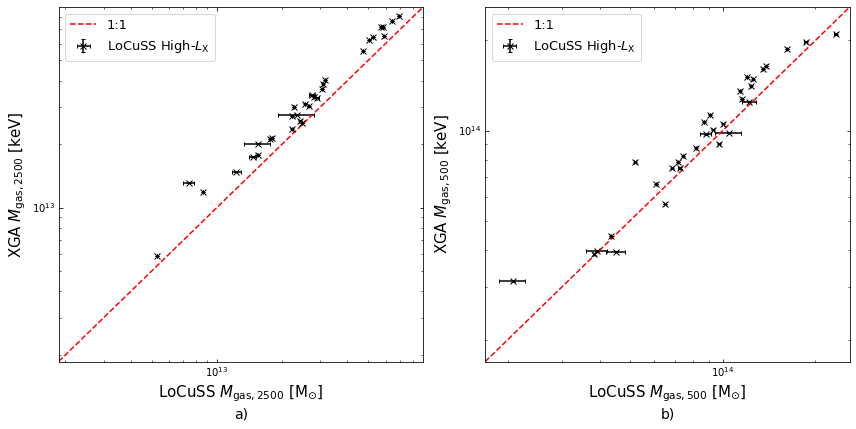

In [20]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_gm2500, 
                                                        loc_dblbeta_svikh_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_1r500_gmcomp_dblbeta_svikh.pdf')